In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

Mounted at /content/drive


In [ ]:
import urllib.request
from PIL import Image
import os
import math

import gmaps

import numpy as np
import cv2
import csv
import os
from matplotlib import pyplot
from google.colab.patches import cv2_imshow


In [ ]:
## Specifying which features are to be extracted.
## Make changes by refering to this link - https://gist.github.com/sebastianleonte/69a5f62220fbf25dca7de86c3b6d23ac


styles=[
  {
    "featureType": "administrative",
    "elementType": "geometry",
    "stylers": [
      {
        "visibility": "off"
      }
    ]
  },
  {
    "featureType": "poi",
    "stylers": [
      {
        "visibility": "off"
      }
    ]
  },
  {
    "featureType": "road",
    "elementType": "labels.icon",
    "stylers": [
      {
        "visibility": "off"
      }
    ]
  },
  {
    "featureType": "transit",
    "stylers": [
      {
        "visibility": "off"
      }
    ]
  },
  {
    "featureType": "water",
    "stylers": [
      {
        "color": "#0f1848"
      },
      {
        "visibility": "on"
      }
    ]
  },
  {
    "featureType": "water",
    "elementType": "labels.text",
    "stylers": [
      {
        "color": "#f4f5fa"
      }
    ]
  }
]
""" What I used for road
styles = [
    {
      "elementType": "labels",
      "stylers": [{"visibility": "off"}]
    },
    {
    "featureType": "road",
    "elementType": "geometry",
    "stylers": [{"color": "#304a7d"}]
    },
    {
    "featureType": "road.highway",
    "elementType": "geometry",
    "stylers": [{"color": "#2c6675"}]},
   {
    "featureType": "road.highway",
    "elementType": "geometry.stroke",
    "stylers": [{"color": "#255763"}]
   }
 ]
"""

' What I used for road\nstyles = [\n    { \n      "elementType": "labels",\n      "stylers": [{"visibility": "off"}]\n    },\n    {\n    "featureType": "road",\n    "elementType": "geometry",\n    "stylers": [{"color": "#304a7d"}]\n    },\n    {\n    "featureType": "road.highway",\n    "elementType": "geometry",\n    "stylers": [{"color": "#2c6675"}]},\n   {\n    "featureType": "road.highway",\n    "elementType": "geometry.stroke",\n    "stylers": [{"color": "#255763"}]\n   }\n ]\n'

In [ ]:
## Token returned specifies the styles applied
sty = gmaps.decode_style(styles)

In [ ]:
class GoogleMapsLayers:
  ROADMAP = "v"
  TERRAIN = "p"
  ALTERED_ROADMAP = "r"
  SATELLITE = "s"
  TERRAIN_ONLY = "t"
  HYBRID = "y"

In [ ]:
class GoogleMapDownloader:
    """
        A class which generates high resolution google maps images given
        a longitude, latitude and zoom level
    """

    def __init__(self, lat, lng, zoom=12, layer=GoogleMapsLayers.ROADMAP):
        """
            GoogleMapDownloader Constructor
            Args:
                lat:    The latitude of the location required
                lng:    The longitude of the location required
                zoom:   The zoom level of the location required, ranges from 0 - 23
                        defaults to 12
        """
        self._lat = lat
        self._lng = lng
        self._zoom = zoom
        self._layer = layer

    def getXY(self):
        """
            Generates an X,Y tile coordinate based on the latitude, longitude
            and zoom level
            Returns:    An X,Y tile coordinate
        """

        tile_size = 256

        # Use a left shift to get the power of 2
        # i.e. a zoom level of 2 will have 2^2 = 4 tiles
        numTiles = 1 << self._zoom

        # Find the x_point given the longitude
        point_x = (tile_size / 2 + self._lng * tile_size / 360.0) * numTiles // tile_size

        # Convert the latitude to radians and take the sine
        sin_y = math.sin(self._lat * (math.pi / 180.0))

        # Calulate the y coordinate
        point_y = ((tile_size / 2) + 0.5 * math.log((1 + sin_y) / (1 - sin_y)) * -(
        tile_size / (2 * math.pi))) * numTiles // tile_size

        return int(point_x), int(point_y)

    def generateImage(self, **kwargs):
        """
            Generates an image by stitching a number of google map tiles together.
            Args:
                start_x:        The top-left x-tile coordinate
                start_y:        The top-left y-tile coordinate
                tile_width:     The number of tiles wide the image should be -
                                defaults to 5
                tile_height:    The number of tiles high the image should be -
                                defaults to 5
            Returns:
                A high-resolution Google Map image.
        """

        start_x = kwargs.get('start_x', None)
        start_y = kwargs.get('start_y', None)
        tile_width = kwargs.get('tile_width', 5)
        tile_height = kwargs.get('tile_height', 5)

        # Check that we have x and y tile coordinates
        if start_x == None or start_y == None:
            start_x, start_y = self.getXY()

        # Determine the size of the image
        width, height = 256 * tile_width, 256 * tile_height

        # Create a new image of the size require
        map_img = Image.new('RGB', (width, height))

        for x in range(0, tile_width):
            for y in range(0, tile_height):
                url = f'https://mt0.google.com/vt?lyrs={self._layer}&x=' + str(start_x + x) + '&y=' + str(start_y + y) + '&z=' + str(self._zoom) + '&apistyle='+sty

                current_tile = str(x) + '-' + str(y)
                urllib.request.urlretrieve(url, current_tile)

                im = Image.open(current_tile)
                map_img.paste(im, (x * 256, y * 256))

                os.remove(current_tile)

        return map_img


In [ ]:
#'/content/drive/Shareddrives/FYP/coordinates.csv'
with open('/content/drive/Shareddrives/FYP/Virudhunagar/coordinates.csv', 'r', encoding='UTF8') as f:
    csvFile = csv.reader(f)

    # displaying the contents of the CSV file
    for lines in csvFile:
      if lines[0]!='id':
        x,y = round(float(lines[1]),4), round(float(lines[2]),4)
        print(x,y)

        # Create a new instance of GoogleMap Downloader
        gmd = GoogleMapDownloader(x,y,18 , GoogleMapsLayers.SATELLITE)#ALTERED_ROADMAP) ## use GoogleMapsLayers.SATELLITE for normal

        print(f"The tile coordinates are {gmd.getXY()}")

        try:
            # Get the high resolution image
            img = gmd.generateImage()
        except IOError:
            print("Could not generate the image - try adjusting the zoom level and checking your coordinates")
        else:
            # Save the image to disk
            img.save(f"/content/drive/Shareddrives/FYP/Virudhunagar/satellite/img_{x}_{y}.png")

            ## Normal images : img.save(f"/content/drive/Shareddrives/FYP/SatelliteImages-Normal/img_{x}_{y}.png")
            ## Road images : img.save(f"/content/drive/Shareddrives/FYP/SegmentedRoadImages/img_{x}_{y}.png")
            ## Water images : img.save(f"/content/drive/Shareddrives/FYP/SegmentedWaterImages/img_{x}_{y}.png")
            print("The map has successfully been created")

9.4444 77.902
The tile coordinates are (187798, 124163)
Could not generate the image - try adjusting the zoom level and checking your coordinates
9.4698 77.9687
The tile coordinates are (187847, 124144)
Could not generate the image - try adjusting the zoom level and checking your coordinates
9.516 77.8529
The tile coordinates are (187762, 124110)
Could not generate the image - try adjusting the zoom level and checking your coordinates
9.6269 77.9856
The tile coordinates are (187859, 124028)
Could not generate the image - try adjusting the zoom level and checking your coordinates
9.5749 77.9465
The tile coordinates are (187830, 124067)
Could not generate the image - try adjusting the zoom level and checking your coordinates
9.5196 78.0248
The tile coordinates are (187887, 124107)
Could not generate the image - try adjusting the zoom level and checking your coordinates
9.4557 77.9067
The tile coordinates are (187801, 124155)
Could not generate the image - try adjusting the zoom level and

In [ ]:
from matplotlib import pyplot
pyplot.rcParams['figure.figsize'] = [15, 15]
def plot(img1,img2):
  f, axarr = pyplot.subplots(1,2)
  axarr[0].imshow(img2)
  axarr[1].imshow(img1)


In [ ]:
with open('/content/drive/Shareddrives/FYP/Virudhunagar/coordinates.csv', 'r', encoding='UTF8') as f:
    csvFile = csv.reader(f)

    # displaying the contents of the CSV file
    i = 0
    for lines in csvFile:
      if lines[0]!='id':
        x,y = round(float(lines[1]),4), round(float(lines[2]),4)
        print(x,y)

        # Create a new instance of GoogleMap Downloader
        gmd1 = GoogleMapDownloader(x,y, 18, GoogleMapsLayers.SATELLITE)#ALTERED_ROADMAP) ## use GoogleMapsLayers.SATELLITE for normal
        gmd2 = GoogleMapDownloader(x,y, 18, GoogleMapsLayers.SATELLITE)

        #print(f"The tile coordinates are {gmd1.getXY()}")
        #print(f"\nThe tile coordinates are {gmd2.getXY()}")

        try:
            # Get the high resolution image
            img1 = gmd1.generateImage()
            img2 = gmd2.generateImage()

        except IOError:
            print("Could not generate the image - try adjusting the zoom level and checking your coordinates")
        else:
            plot(img1,img2)
            #img1.save(f"/content/drive/Shareddrives/FYP/Virudhunagar/water/{x}_{y}.png")
            #img2.save("/content/image.png")
            print("The map has successfully been created")
        i+=1
        if i==10:
          break


9.4444 77.902
Could not generate the image - try adjusting the zoom level and checking your coordinates
9.4698 77.9687
Could not generate the image - try adjusting the zoom level and checking your coordinates
9.516 77.8529
Could not generate the image - try adjusting the zoom level and checking your coordinates
9.6269 77.9856
Could not generate the image - try adjusting the zoom level and checking your coordinates
9.5749 77.9465
Could not generate the image - try adjusting the zoom level and checking your coordinates
9.5196 78.0248
Could not generate the image - try adjusting the zoom level and checking your coordinates
9.4557 77.9067
Could not generate the image - try adjusting the zoom level and checking your coordinates
9.471 77.9119
Could not generate the image - try adjusting the zoom level and checking your coordinates
9.5469 77.9219
Could not generate the image - try adjusting the zoom level and checking your coordinates
9.4493 77.9009
Could not generate the image - try adjustin

The below function is not really required anymore since we can use tha api to colour the roads.

In [ ]:
## Function the invert the images to obtain the road masks
def conv(img):

  img = cv2.imread(img)
  kernel = np.ones((5, 5), np.uint8)

  # converting the image to HSV format
  hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

  # defining the lower and upper values
  # of HSV, this will detect yellow (## white for us) colour
  # 0-255, 0-255, 255
  Lower_hsv = np.array([0, 0, 255])
  Upper_hsv = np.array([255, 255, 255])

  # creating the mask
  Mask = cv2.inRange(hsv, Lower_hsv, Upper_hsv)

  # Inverting the mask
  mask_yellow = cv2.bitwise_not(Mask)
  Mask = cv2.bitwise_and(img, img, mask = mask_yellow)

  return Mask

In [ ]:
## Reading each saved images then converting to the inverted masks and saving with the same name
for img in os.listdir("/content/drive/Shareddrives/FYP/SegmentedRoadImages"):
  im = conv("/content/drive/Shareddrives/FYP/SegmentedRoadImages/"+img)
  cv2.imwrite("/content/drive/Shareddrives/FYP/SegmentedRoadImages/"+img,im)


Testing code - saves only 1 image

In [ ]:
x,y = 9.487939, 77.793636
print(x,y)

# Create a new instance of GoogleMap Downloader
#gmd = GoogleMapDownloader(x,y, 18, GoogleMapsLayers.SATELLITE)#ALTERED_ROADMAP)#SATELLITE)
gmd2 = GoogleMapDownloader(x,y, 15, GoogleMapsLayers.ALTERED_ROADMAP)

#print(f"The tile coordinates are {gmd.getXY()}")

try:
    # Get the high resolution image
    #img = gmd.generateImage()
    img2 = gmd2.generateImage()
except IOError:
    print("Could not generate the image - try adjusting the zoom level and checking your coordinates")
else:
    # Save the image to disk
    #img.save("/content/sample.png")
    img2.save("/content/mask.png")
    print("The map has successfully been created")

9.487939 77.793636
The map has successfully been created


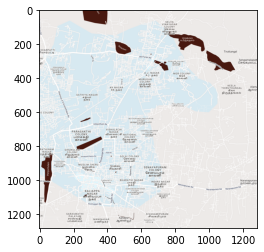

In [ ]:
## Reading and displaying a single images
img=cv2.imread("/content/mask.png")
pyplot.imshow(img)

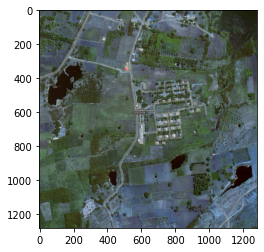

In [ ]:
## Reading and displaying a single images
img=cv2.imread("/content/mask.png")
pyplot.imshow(img)